Here are all the libraries we need:

In [131]:
import axelrod as axl  # The library itself
import csv  # To read in our data file
import pandas  # To manage the data
import numpy as np  # For a quick mean, media

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

## Reading in the data

Now to analyse the results.

In [168]:
def make_df(row, df, i=0):
    data = []
    for ele in list(df.ix[row,1:]):
        data.append([eval(ele)[0].split(";")] + [list(eval(ele)[1])[i], list(eval(ele)[2 + i])])
    return pandas.DataFrame(data, columns=["Strategies", "Rank", "Wins"])

def make_rank_plot(df, filename):
    """Function to plot rank"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Rank")
    y = np.array([d["Rank"] for d in df["Data"]])
    x = np.array(range(1, len(y) + 1))
    m,b = np.polyfit(x, [np.median(vlue) for vlue  in y], 1)
    plt.title("{} (fit: $y={:.2f}x+{:.2f}$)".format(filename, m, b))
    plt.plot(x, m * x + b)
    plt.boxplot([d["Rank"] for d in df["Data"]])
    plt.savefig('rank-' + filename + '.svg')
    return plt, m, b

def make_proportional_rank_plot(df, filename):
    """Function to plot normalised rank"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Proportional rank")
    mean_prop_rank = np.mean([d["Rank"] / (len(d["Strategies"][0])) for d in df["Data"]])
    plt.title("{} (mean: {:.2f})".format(filename, mean_prop_rank))
    return plt.boxplot([d["Rank"] / (len(d["Strategies"][0])) for d in df["Data"]])

def make_wins_plot(df, filename):
    """Function to plot wins"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Wins")

    
    y = np.array([[np.mean(r) for r in d["Wins"]] for d in df["Data"]])
    x = np.array(range(1, len(y) + 1))
    m,b = np.polyfit(x, [np.median(vlue) for vlue  in y], 1)
    plt.title("{} (fit: $y={:.2f}x+{:.2f}$)".format(filename, m, b))
    plt.plot(x, m * x + b)
    plt.boxplot([[np.mean(r) for r in d["Wins"]] for d in df["Data"]])
    plt.savefig('wins-' + filename + '.svg')
    return plt, m, b

def make_proportional_wins_plot(df, filename):
    """Function to plot normalised wins"""
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of opponents")
    plt.ylabel("Proportional wins")
    mean_prop_wins = np.mean([np.mean([np.mean(r)  / (len(d["Strategies"][0])) for r in d["Wins"]]) for d in df["Data"]])
    plt.title("{} (mean: {:.2f})".format(filename, mean_prop_wins))
    return plt.boxplot([[np.mean(r) /  (len(d["Strategies"][0])) for r in d["Wins"]] for d in df["Data"]])


def read_data_and_plot(data_file):
    raw_df = pandas.read_csv(data_file, header=None)

    df = pandas.DataFrame([[row + 3, make_df(row, raw_df)] for row in range(len(raw_df))], columns=["Strategies", "Data"])

    _, m_rank, b_rank = make_rank_plot(df, data_file[5:-4]);
   # make_proportional_rank_plot(df, data_file);
    _, m_win, b_win = make_wins_plot(df, data_file[5:-4]);
   # make_proportional_wins_plot(df, data_file);
    return m_rank, b_rank, m_win, b_win

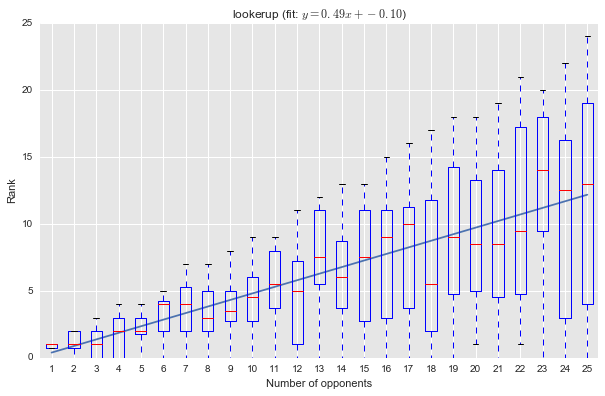

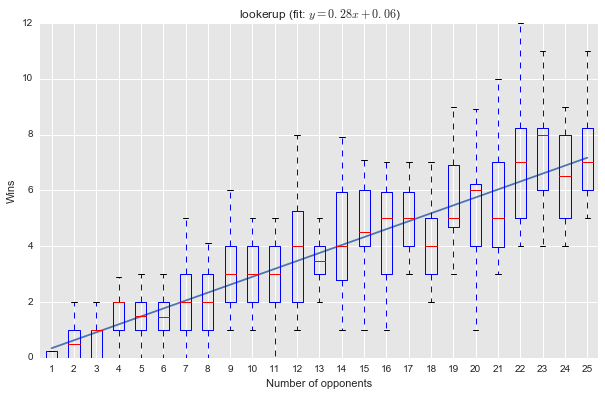

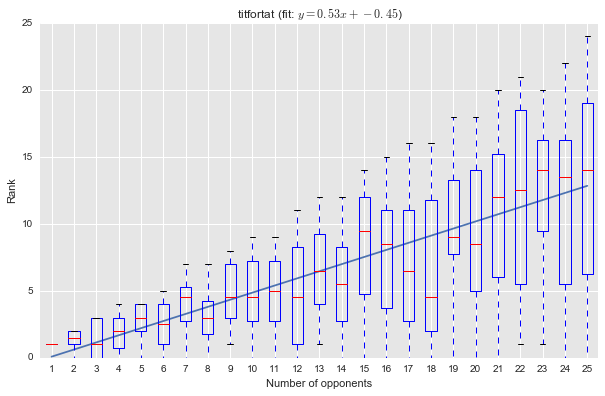

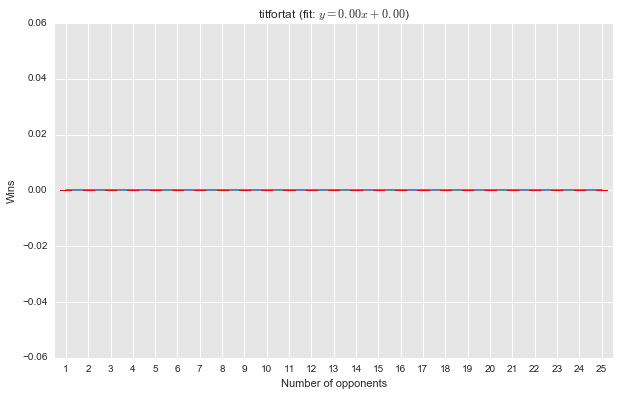

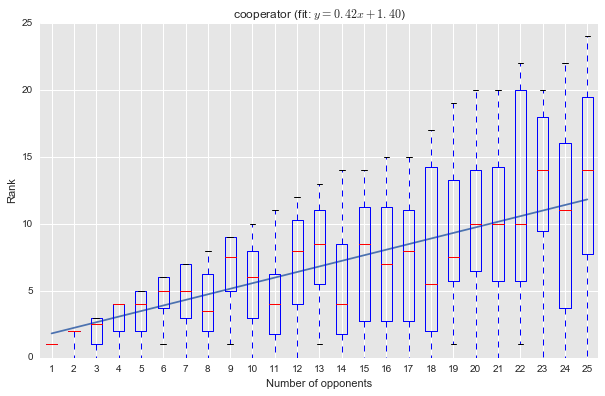

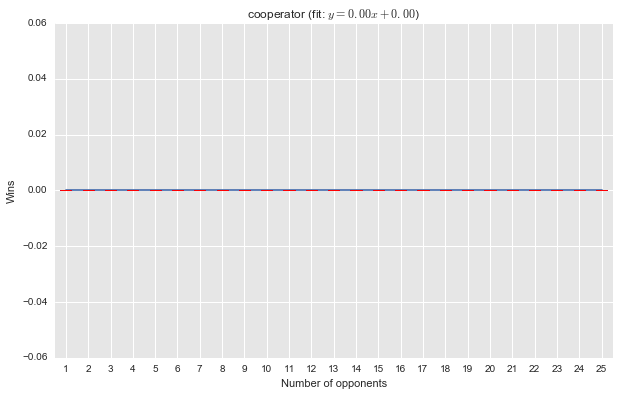

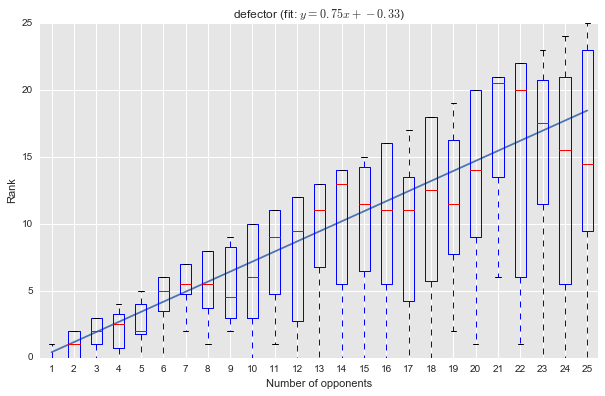

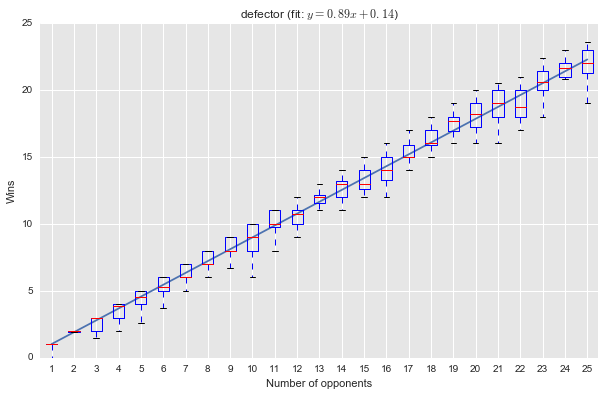

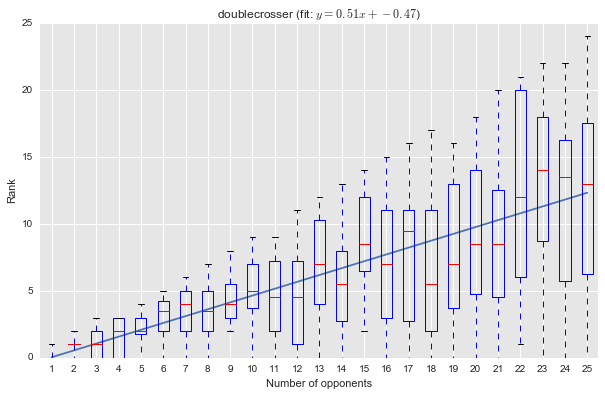

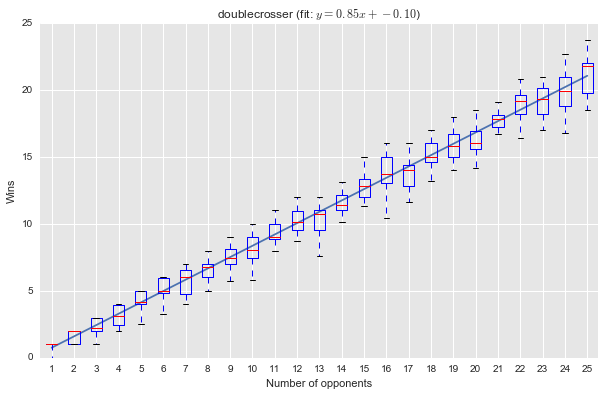

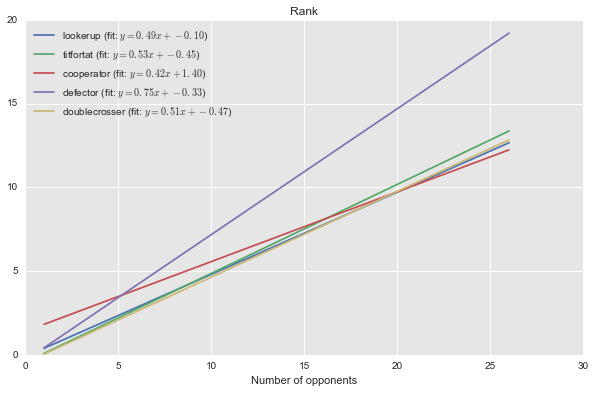

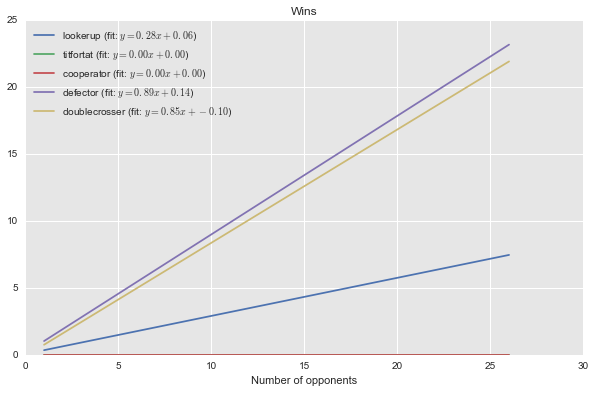

In [175]:
ms_rank = []
bs_rank = []
ms_win = []
bs_win = []
files = ["data-lookerup.csv", "data-titfortat.csv", "data-cooperator.csv", "data-defector.csv", "data-doublecrosser.csv"]
for data_file in files:
    m_rank, b_rank, m_win, b_win = read_data_and_plot(data_file)
    ms_rank.append(m_rank)
    bs_rank.append(b_rank)
    ms_win.append(m_win)
    bs_win.append(b_win)

plt.figure(figsize=(10, 6))
x = np.array(range(1, 26 + 1))
for i, fit in enumerate(zip(ms_rank, bs_rank)):
    m, b = fit[0], fit[1]
    plt.plot(x, m * x + b, label="{} (fit: $y={:.2f}x+{:.2f}$)".format(files[i][5:-4], m, b))
plt.legend(loc=2)
plt.title("Rank");
plt.xlabel("Number of opponents")
plt.savefig("rank-regression.svg");

plt.figure(figsize=(10, 6))
x = np.array(range(1, 26 + 1))
for i, fit in enumerate(zip(ms_win, bs_win)):
    m, b = fit[0], fit[1]
    plt.plot(x, m * x + b, label="{} (fit: $y={:.2f}x+{:.2f}$)".format(files[i][5:-4], m, b))
plt.legend(loc=2)
plt.title("Wins");
plt.xlabel("Number of opponents")
plt.savefig("wins-regression.svg");

We can also look at combined experiments (so when the test strategies are all included with a random sample).

In [170]:
combined_raw_df = pandas.read_csv("combined-data", header=None)

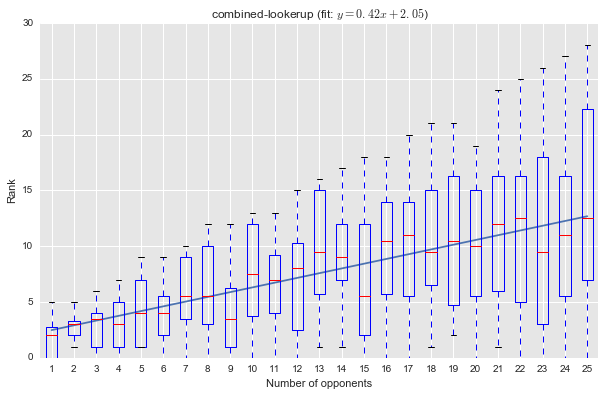

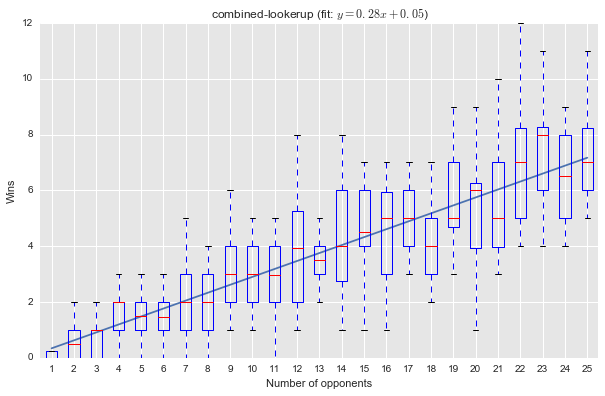

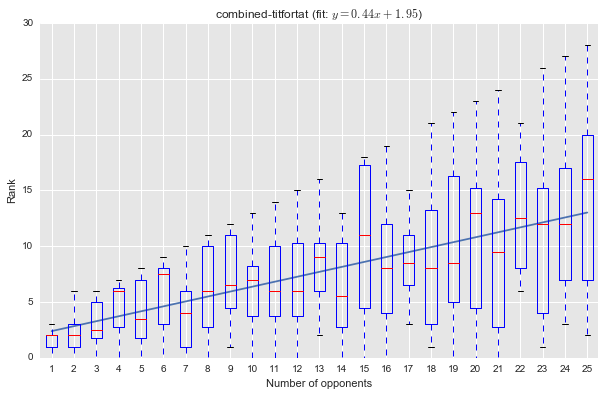

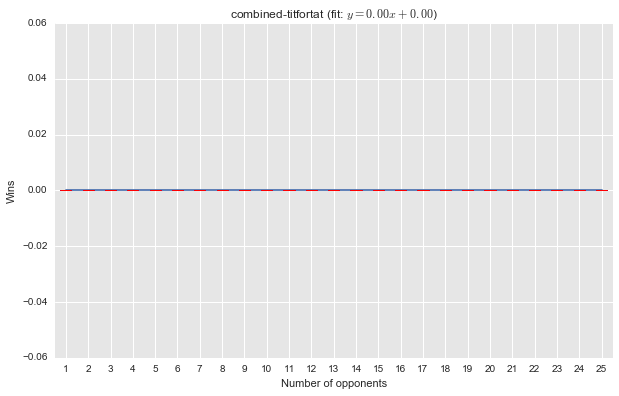

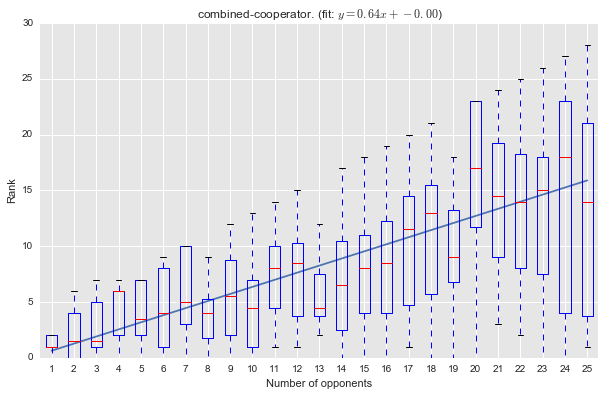

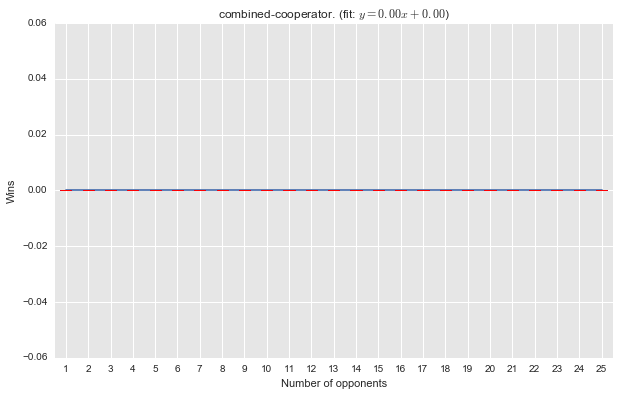

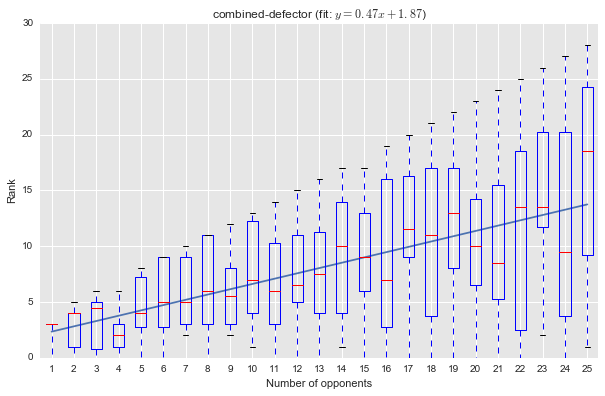

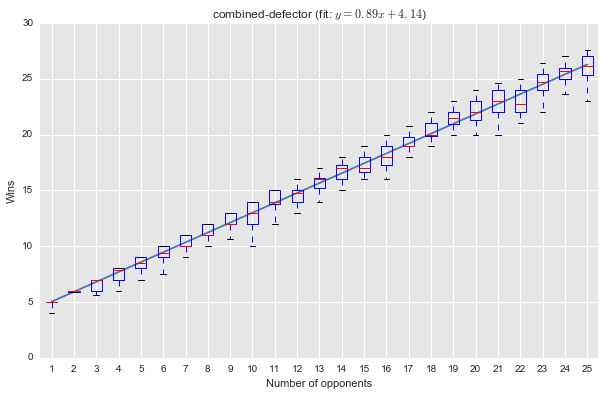

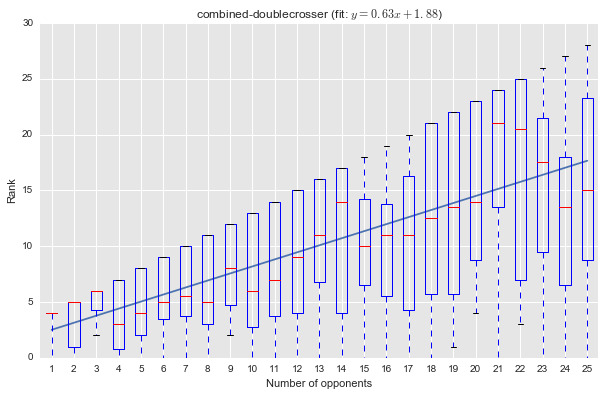

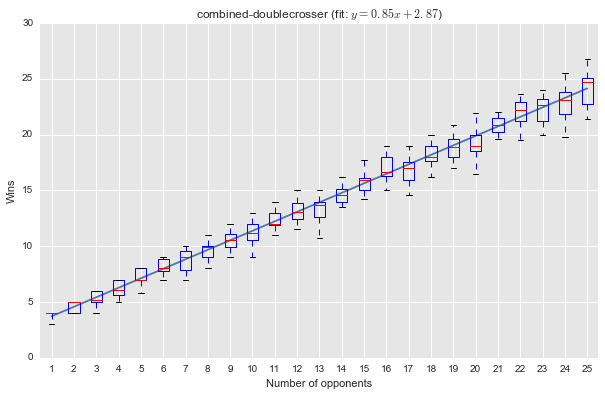

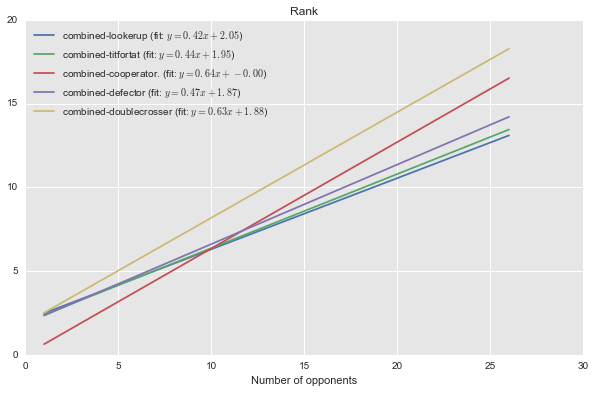

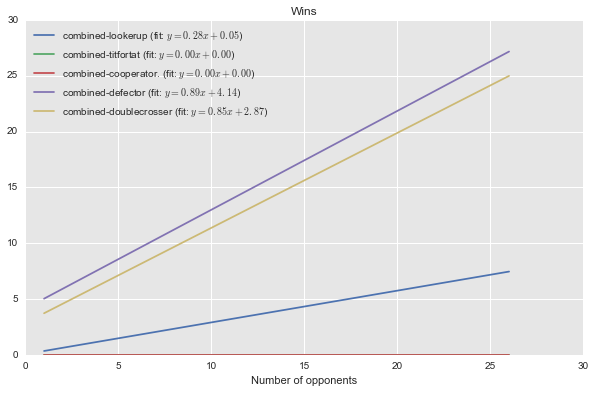

In [176]:
test_strategies = ["combined-lookerup", "combined-titfortat", "combined-cooperator.", "combined-defector", "combined-doublecrosser"]
ms_rank = []
bs_rank = []
ms_win = []
bs_win = []

for i, name in enumerate(test_strategies):
    df = pandas.DataFrame([[row + 3, make_df(row, combined_raw_df, i)] for row in range(len(combined_raw_df))], columns=["Strategies", "Data"])

    
    _, m_rank, b_rank = make_rank_plot(df, name);
   # make_proportional_rank_plot(df, name);
    _, m_win, b_win = make_wins_plot(df, name);
   # make_proportional_wins_plot(df, name);
  
    ms_rank.append(m_rank)
    bs_rank.append(b_rank)
    ms_win.append(m_win)
    bs_win.append(b_win)
    
plt.figure(figsize=(10, 6))
x = np.array(range(1, 26 + 1))
for i, fit in enumerate(zip(ms_rank, bs_rank)):
    m, b = fit[0], fit[1]
    plt.plot(x, m * x + b, label="{} (fit: $y={:.2f}x+{:.2f}$)".format(test_strategies[i], m, b))
plt.legend(loc=2)
plt.title("Rank")
plt.xlabel("Number of opponents")
plt.savefig("combined-rank-regression.svg");

plt.figure(figsize=(10, 6))
x = np.array(range(1, 26 + 1))
for i, fit in enumerate(zip(ms_win, bs_win)):
    m, b = fit[0], fit[1]
    plt.plot(x, m * x + b, label="{} (fit: $y={:.2f}x+{:.2f}$)".format(test_strategies[i], m, b))
plt.legend(loc=2)
plt.title("Wins")
plt.xlabel("Number of opponents")
plt.savefig("combined-win-regression.svg");